In [223]:
# Import libraries

import numpy
import matplotlib.pyplot
import scipy.special
from datetime import datetime
import csv
import os
from PIL import Image
%matplotlib inline

In [224]:
# constants

SIZE_OF_IMG = 28

LETTERS = ['O', 'I']
#LETTERS = ['A', 'B', 'C', 'D', 'E']
# LETTERS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
#           'W', 'X', 'Y', 'Z']

SRC_PATH = "C:\Users\domin\Downloads\gzip\\byclass\\"
PATH_SEPARATOR = "\\"

In [225]:
# Class for Neural Network


class NeuralNetwork:
    def __init__(self, learningRate, inputNodes, hiddenNodes, outputNodes):
        self.iNodes = inputNodes
        self.hNodes = hiddenNodes
        self.oNodes = outputNodes
        self.lr = learningRate

        self.wih = numpy.random.normal(0.0, pow(self.hNodes, -0.5), (self.hNodes, self.iNodes))
        self.who = numpy.random.normal(0.0, pow(self.oNodes, -0.5), (self.oNodes, self.hNodes))

        self.activationFunction = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)


        pass

    def train(self, inputList, targetList):
        inputs = numpy.array(inputList, ndmin=2).T
        targets = numpy.array(targetList, ndmin=2).T

        hiddenInputs = numpy.dot(self.wih, inputs)
        hiddenOutputs = self.activationFunction(hiddenInputs)
        finalInputs = numpy.dot(self.who, hiddenInputs)
        finalOutputs = self.activationFunction(finalInputs)

        outputErrors = targets - finalOutputs
        hiddenErrors = numpy.dot(self.who.T, outputErrors)

        self.who += self.lr * numpy.dot((outputErrors * finalOutputs * (1.0 - finalOutputs)), numpy.transpose(hiddenOutputs))
        self.wih += self.lr * numpy.dot((hiddenErrors * hiddenOutputs * (1.0 - hiddenOutputs)), numpy.transpose(inputs))

        pass

    def query(self, inputList):
        inputs = numpy.array(inputList, ndmin=2).T
        hiddenInputs = numpy.dot(self.wih, inputs)
        hiddenOutputs = self.activationFunction(hiddenInputs)
        finalInputs = numpy.dot(self.who, hiddenInputs)
        finalOutputs = self.activationFunction(finalInputs)
        
        return finalOutputs
    
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [226]:
# fetch path

# create array with 'len(letters)' fields
decLetter = {}
for letter in LETTERS:
    decLetter[letter] = str(ord(letter))
    pass

mappingKey = {}
textDataStream = open(SRC_PATH + "emnist-byclass-mapping.txt")
for line in textDataStream:
    splittedLine = line.split(" ")
    mappingKey[splittedLine[1].replace("\n", "")] = splittedLine[0]
    pass

In [227]:
# Training instance of Neural Network


class Training:
        
    startTime = 0
    endTime = 0
    duration = 0
    
    SIZE_OF_TRAINING_DATASET = 0
    EPOCHS = 0
    
    DIR_TRAINING = SRC_PATH + "training\\"
    
    def __init__(self, size_of_dataset, epochs=1):
        self.SIZE_OF_TRAINING_DATASET = size_of_dataset
        self.EPOCHS = epochs
        pass
    
    def start(self):
        self.startTime = datetime.utcnow()
        targetArray = numpy.eye(len(LETTERS), len(LETTERS)) * 0.99
        imageNames = {}
        for letter in LETTERS:
            imageNames[letter] = os.listdir(self.DIR_TRAINING + mappingKey[decLetter[letter]] + PATH_SEPARATOR)
            pass
        
        for epoch in range(self.EPOCHS):
            for iteration in range(self.SIZE_OF_TRAINING_DATASET):
                for letterI in range(len(LETTERS)):
                    path = self.DIR_TRAINING + mappingKey[decLetter[LETTERS[letterI]]] + PATH_SEPARATOR + imageNames[LETTERS[letterI]][iteration]
                    im = Image.open(path)
                            
                    inputArray = numpy.zeros([SIZE_OF_IMG * SIZE_OF_IMG])
                    for y in range(SIZE_OF_IMG):
                        for x in range(SIZE_OF_IMG):
                            px = im.getpixel((y, x))
                            inputArray[(y * SIZE_OF_IMG) + x] = (float(px) / 255 * 0.99) + 0.01
                            pass
                        pass
                    
                    neuralNetwork.train(inputArray, targetArray[:, letterI])
                    pass
#                print("Epoche: " + str(epoch) + "\tIteration: " + str(iteration))
    #           print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S:.%f')[:-3] + ": After training the cycle \n")
                pass
            pass
        self.endTime = datetime.utcnow()
        self.duration = self.endTime - self.startTime
        pass


In [228]:
# Testing instance of Neural Network


class Testing:
    
    
    startTime = 0
    endTime = 0
    duration = 0
    
    scorecard = []
    
    SIZE_OF_TEST_DATASET = 0
    
    DIR_TEST = SRC_PATH + "testing\\"
    
    def __init__(self, size_of_dataset):
        self.SIZE_OF_TEST_DATASET = size_of_dataset
        pass
    
    def start(self):    
        self.startTime = datetime.utcnow()
        imageNames = {}
        for letter in LETTERS:
            imageNames[letter] = os.listdir(self.DIR_TEST + mappingKey[decLetter[letter]] + PATH_SEPARATOR)
            pass
        
        for iteration in range(self.SIZE_OF_TEST_DATASET):
            for letterI in range(len(LETTERS)):
                path = self.DIR_TEST + mappingKey[decLetter[LETTERS[letterI]]] + PATH_SEPARATOR + imageNames[LETTERS[letterI]][iteration]
                im = Image.open(path)
                        
                inputArray = numpy.zeros([SIZE_OF_IMG * SIZE_OF_IMG])
                for y in range(SIZE_OF_IMG):
                    for x in range(SIZE_OF_IMG):
                        px = im.getpixel((y, x))
                        inputArray[(y * SIZE_OF_IMG) + x] = (float(px) / 255 * 0.99) + 0.01
                        pass
                    pass
        
                output = neuralNetwork.query(inputArray)
                label = numpy.argmax(output)
                if label == letterI:
                    self.scorecard.append(1)
                else: 
                    self.scorecard.append(0)
                    pass
                pass
            pass
        self.endTime = datetime.utcnow()
        self.duration = self.endTime - self.startTime
        pass
    
    def getPerformance(self):
        scorecard_array = numpy.asarray(self.scorecard)
        return float(scorecard_array.sum()) / float(scorecard_array.size)

In [229]:
# Class for monitoring Neural Network


class Monitor:
    
    neuralNetwork = None
    training = None
    testing = None
    
    PATH = "\\log\\"
        
    def __init__(self, neuralNetwork=NeuralNetwork, training=Training, testing=Testing):
        self.neuralNetwork = neuralNetwork
        self.training = training
        self.testing = testing
        pass
    
    def writeLog(self):
        file = open(SRC_PATH + self.PATH + "logfile_001.csv", "a")
        writer = csv.writer(file, delimiter=";")
        writer.writerow([self.neuralNetwork.lr,
                        self.training.SIZE_OF_TRAINING_DATASET,
                        self.testing.SIZE_OF_TEST_DATASET,
                        self.training.EPOCHS,
                        self.neuralNetwork.iNodes,
                        self.neuralNetwork.hNodes,
                        self.neuralNetwork.oNodes,
                        len(LETTERS),
                        self.testing.getPerformance(),
                        self.training.startTime.strftime('%Y-%m-%d %H:%M:%S:.%f')[:-3],
                        self.training.endTime.strftime('%Y-%m-%d %H:%M:%S:.%f')[:-3],
                        self.training.duration,
                        self.testing.startTime.strftime('%Y-%m-%d %H:%M:%S:.%f')[:-3],
                        self.testing.endTime.strftime('%Y-%m-%d %H:%M:%S:.%f')[:-3],
                        self.testing.duration,
                        self.training.duration + self.testing.duration])
        file.close()
        pass

In [230]:
# Creating instance of Neural Network

inputNodes = SIZE_OF_IMG * SIZE_OF_IMG
hiddenNodes = 400
outputNodes = len(LETTERS)
learningrate = 0.1

sizeOfTrainingDataset = 2460
epochs = 1

sizeOfTestDataset = 380

print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S:.%f')[:-3])

neuralNetwork = NeuralNetwork(learningrate, inputNodes, hiddenNodes, outputNodes)

training = Training(sizeOfTrainingDataset, epochs)
training.start()

testing = Testing(sizeOfTestDataset)
testing.start()

monitor = Monitor(neuralNetwork, training, testing)
monitor.writeLog()

print("Performance: " + str(testing.getPerformance()))
print("Duration: " + str(testing.duration + training.duration))

2018-05-20 22:33:21:.275


Performance: 0.994736842105
Duration: 0:00:37.442000


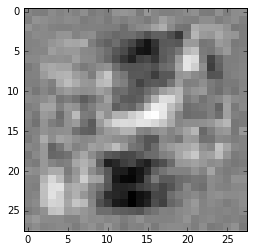

In [231]:
targetArray = (numpy.eye(len(LETTERS), len(LETTERS)) * 0.98) + 0.01
inputsArray = neuralNetwork.backquery(targetArray[:, 0])
matplotlib.pyplot.imshow(inputsArray.reshape(28, 28), cmap="Greys", interpolation="None")



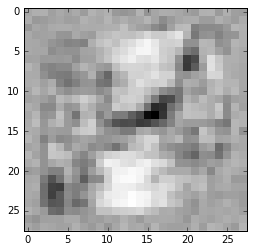

In [232]:
inputsArray2 = neuralNetwork.backquery(targetArray[1, :])
matplotlib.pyplot.imshow(inputsArray2.reshape(28, 28), cmap="Greys", interpolation="None")


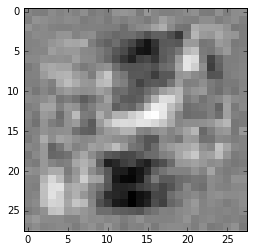

In [239]:
inputsArray = neuralNetwork.backquery(targetArray[:, 0])
matplotlib.pyplot.imshow(inputsArray.reshape(28, 28), cmap="Greys", interpolation="None")


In [234]:
inputsArray = neuralNetwork.backquery(targetArray[:, 3])
matplotlib.pyplot.imshow(inputsArray.reshape(28, 28), cmap="Greys", interpolation="None")


IndexError: index 3 is out of bounds for axis 1 with size 2

In [235]:
inputsArray = neuralNetwork.backquery(targetArray[:, 2])
matplotlib.pyplot.imshow(inputsArray.reshape(28, 28), cmap="Greys", interpolation="None")
print(inputsArray)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [236]:
print(targetArray[4, :])

IndexError: index 4 is out of bounds for axis 0 with size 2

In [237]:
print(inputsArray)

[[ 0.55718465]
 [ 0.57872911]
 [ 0.58751125]
 [ 0.5323373 ]
 [ 0.56209972]
 [ 0.5418762 ]
 [ 0.56598222]
 [ 0.52281526]
 [ 0.59250959]
 [ 0.56141371]
 [ 0.58530989]
 [ 0.51193208]
 [ 0.49915791]
 [ 0.51485634]
 [ 0.59193029]
 [ 0.49241396]
 [ 0.55008676]
 [ 0.57310052]
 [ 0.57334471]
 [ 0.55917826]
 [ 0.53749375]
 [ 0.51838895]
 [ 0.58678155]
 [ 0.5942364 ]
 [ 0.51781678]
 [ 0.58257601]
 [ 0.53114161]
 [ 0.52667542]
 [ 0.57415615]
 [ 0.50851839]
 [ 0.5216375 ]
 [ 0.53971016]
 [ 0.55540295]
 [ 0.529228  ]
 [ 0.53823345]
 [ 0.58873448]
 [ 0.5676917 ]
 [ 0.55417905]
 [ 0.59671501]
 [ 0.55518986]
 [ 0.57931224]
 [ 0.55038014]
 [ 0.55907407]
 [ 0.59838045]
 [ 0.54701494]
 [ 0.46670249]
 [ 0.51398791]
 [ 0.55296214]
 [ 0.57001596]
 [ 0.57400974]
 [ 0.52441396]
 [ 0.52407952]
 [ 0.58088933]
 [ 0.55357012]
 [ 0.5248421 ]
 [ 0.56902571]
 [ 0.50570975]
 [ 0.55413374]
 [ 0.53481943]
 [ 0.56614667]
 [ 0.57354372]
 [ 0.57429096]
 [ 0.56040581]
 [ 0.57100352]
 [ 0.56737335]
 [ 0.57581502]
 [ 0.57742